# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
import pandas as pd
import numpy as np

# for model
import tensorflow as tf
!pip install transformers -q
import transformers
from transformers import TFRobertaModel, RobertaTokenizer
from sklearn.metrics import classification_report


# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get the data

cola_balanced_train.to_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_balanced_train.csv', index=False)
cola_validation.to_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_validation.csv', index=False)
cola_test.to_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_test.csv', index=False)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_balanced_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/266/Data/Clean_Data/CoLA/cola_test.csv')



In [ ]:
train_df.head()

,sentence,acceptability
0,To please John is tough.,1
1,John did not like Mary.,1
2,John is not more reliable a fellow than Bill.,0
3,Joan knew the answer.,1
4,The baby dressed.,1


In [ ]:
val_df.head()

,sentence,acceptability
0,Which man did you talk to?,1
1,What she thought was that the poison was neutr...,1
2,The teacher made students happy.,1
3,I have sent 0 letter to Environmental Heath.,0
4,We believed to be omnipotent.,0


In [ ]:
test_df.head()

,sentence,acceptability
0,The sailors rode the breeze clear of the rocks.,1
1,The weights made the rope stretch over the pul...,1
2,The mechanical doll wriggled itself loose.,1
3,"If you had eaten more, you would want less.",1
4,"As you eat the most, you want the least.",0


In [ ]:
print("Number of acceptable/unacceptable sentences in training set")
print("-"*60)
train_df['acceptability'].value_counts()

Number of acceptable/unacceptable sentences in training set
------------------------------------------------------------


1    4802
0    4802
Name: acceptability, dtype: int64

In [ ]:
print("Number of acceptable/unacceptable sentences in validation set")
print("-"*61)
val_df['acceptability'].value_counts()

Number of acceptable/unacceptable sentences in validation set
-------------------------------------------------------------


1    1221
0     490
Name: acceptability, dtype: int64

In [ ]:
print("Number of acceptable/unacceptable sentences in test set")
print("-"*55)
test_df['acceptability'].value_counts()

Number of acceptable/unacceptable sentences in test set
-------------------------------------------------------


1    719
0    324
Name: acceptability, dtype: int64

In [ ]:
acc = round(len(train_df[train_df['acceptability'] == 1]) / len(train_df)*100)
print(f'Percentage of training instances which are acceptable: {acc}%')

Percentage of training instances which are acceptable: 50%


In [ ]:
acc = round(len(val_df[val_df['acceptability'] == 1]) / len(val_df)*100)
print(f'Percentage of validation instances which are acceptable: {acc}%')

Percentage of validation instances which are acceptable: 71%


In [ ]:
acc = round(len(test_df[test_df['acceptability'] == 1]) / len(test_df)*100)
print(f'Percentage of test instances which are acceptable: {acc}%')

Percentage of test instances which are acceptable: 69%


# Train RoBERTa as a grammatical acceptability classifier on CoLA dataset

In [ ]:
results = {}

In [ ]:
results['all_acceptable'] = len(test_df[test_df['acceptability'] == 0]) / len(test_df)

## Load RoBERTa base




In [ ]:
# Load tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_base_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
roberta_tokenizer

RobertaTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:
# Set global variables
MAX_LEN = 256

## Inspect the model

In [ ]:
# output a sentence
trial_sentence = train_df['sentence'][7]
print("Trial sentence:",trial_sentence)
print("-"*100)

# tokenize it using the RoBERTa tokenizer # 10 token ids vs 8 tokens
tokenized_input = roberta_tokenizer(trial_sentence,return_tensors='tf')

print("Tokens:",tokenized_input)
print("-"*100)
print("BPE tokenization:",roberta_tokenizer.tokenize(trial_sentence))

Trial sentence: The car honked down the road.
----------------------------------------------------------------------------------------------------
Tokens: {'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[    0,   133,   512, 11006, 10916,   159,     5,   921,     4,
            2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
----------------------------------------------------------------------------------------------------
BPE tokenization: ['The', 'Ġcar', 'Ġhon', 'ked', 'Ġdown', 'Ġthe', 'Ġroad', '.']


In [ ]:
roberta_output = roberta_base_model(tokenized_input)
roberta_output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 10, 768), dtype=float32, numpy=
array([[[-0.10391971,  0.09979197, -0.01685934, ..., -0.07474034,
         -0.02287602, -0.03322849],
        [-0.07406615,  0.08485349, -0.01377264, ...,  0.08656158,
          0.00580528, -0.09585881],
        [ 0.14500533,  0.219632  , -0.05300761, ...,  0.63992584,
          0.11180913,  0.09703369],
        ...,
        [-0.14231463,  0.26290646, -0.10450698, ...,  0.00290941,
          0.16913581,  0.06988557],
        [-0.0917401 ,  0.09356798, -0.04420766, ..., -0.09922531,
         -0.02238247, -0.06139484],
        [-0.06992991,  0.09149651, -0.00983183, ...,  0.06129345,
          0.00718148,  0.05413652]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 2.02411771e-01, -2.17887312e-01, -2.40790278e-01,
         2.01939464e-01, -2.11907387e-01,  2.14460239e-01,
         2.20514476e-01, -2.46695597e-02, -1.69030875e-

In [ ]:
print(len(roberta_output))

2


In [ ]:
# last_hidden_state
roberta_output[0] # shape=(1, 10, 1024)

<tf.Tensor: shape=(1, 10, 768), dtype=float32, numpy=
array([[[-0.10391971,  0.09979197, -0.01685934, ..., -0.07474034,
         -0.02287602, -0.03322849],
        [-0.07406615,  0.08485349, -0.01377264, ...,  0.08656158,
          0.00580528, -0.09585881],
        [ 0.14500533,  0.219632  , -0.05300761, ...,  0.63992584,
          0.11180913,  0.09703369],
        ...,
        [-0.14231463,  0.26290646, -0.10450698, ...,  0.00290941,
          0.16913581,  0.06988557],
        [-0.0917401 ,  0.09356798, -0.04420766, ..., -0.09922531,
         -0.02238247, -0.06139484],
        [-0.06992991,  0.09149651, -0.00983183, ...,  0.06129345,
          0.00718148,  0.05413652]]], dtype=float32)>

In [ ]:
# cls token (as per BERT) Which one should we use?????
cls_token = roberta_output[0][:, 0, :]
print("using BERT's cls sample token from notebook",cls_token)

using BERT's cls sample token from notebook tf.Tensor(
[[-1.03919707e-01  9.97919738e-02 -1.68593377e-02 -1.03446573e-01
   1.19844623e-01 -5.72932698e-02 -2.86284275e-02  2.96653733e-02
   2.13041119e-02 -1.06242865e-01 -2.95727048e-02  5.32326847e-02
   4.29881550e-02 -4.95398715e-02  6.59124106e-02 -1.44171314e-02
  -2.30257362e-02  2.69076396e-02  4.75241318e-02 -9.22894552e-02
  -7.67960921e-02 -2.85731442e-03  4.32272255e-02  1.64666474e-01
  -3.24827433e-02  3.69483195e-02  9.37738717e-02  5.18364906e-02
  -4.47262526e-02 -5.77703165e-03 -5.71795963e-02 -7.90716857e-02
   4.27620113e-02 -1.12450905e-02 -7.00816792e-03  9.84497219e-02
   2.71093305e-02 -8.94375890e-03 -5.56801036e-02  3.59586328e-02
  -2.08201278e-02  2.19278783e-01  4.09971625e-02 -1.46622863e-02
   6.14759363e-02 -2.78080069e-02 -1.34382732e-02 -2.85870731e-02
  -5.55358129e-03 -6.14473782e-03 -2.53375247e-03  5.30698448e-02
  -6.80749342e-02  5.66336773e-02 -1.69578835e-01  6.33738488e-02
   6.81076050e-02  3.

In [ ]:
# pooler_output
roberta_output[1] # shape=(1,1024)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 2.02411771e-01, -2.17887312e-01, -2.40790278e-01,
         2.01939464e-01, -2.11907387e-01,  2.14460239e-01,
         2.20514476e-01, -2.46695597e-02, -1.69030875e-02,
        -3.17310914e-02,  4.57944125e-02,  2.72199899e-01,
        -1.96891829e-01,  2.94322092e-02, -2.07148626e-01,
        -1.07842244e-01, -1.79825261e-01,  4.20500219e-01,
        -2.83159345e-01,  1.42334759e-01, -3.92447144e-01,
         4.62617688e-02, -7.63106951e-03, -1.55252099e-01,
         3.72921042e-02, -8.01721811e-02,  2.89763451e-01,
        -2.04848349e-01,  1.02427036e-01,  2.27989197e-01,
        -1.64960593e-01, -3.51871818e-01, -1.32335708e-01,
         1.27977192e-01, -4.82813604e-02, -2.38186896e-01,
        -2.99662203e-02,  3.40008318e-01, -1.65912941e-01,
         5.05255722e-02,  4.75015827e-02,  7.66462162e-02,
        -1.01032101e-01,  5.00626154e-02, -2.71600187e-01,
        -2.03740373e-01,  2.50544429e-01, -2.23803893e-02,
      

## Tokenize the inputs

In [ ]:
# train
x_train = roberta_tokenizer(train_df['sentence'].tolist(),
                            max_length=MAX_LEN,
                            truncation=True,
                            padding='max_length',
                            return_token_type_ids=True,
                            return_tensors='tf')

roberta_train_inputs = [x_train.input_ids,
                        x_train.token_type_ids,
                        x_train.attention_mask]

y_train = np.array(train_df['acceptability'].tolist())





# validation
x_val = roberta_tokenizer(val_df['sentence'].tolist(),
                           max_length=MAX_LEN,
                           truncation=True,
                           padding='max_length',
                           return_token_type_ids=True,
                           return_tensors='tf')

roberta_val_inputs = [x_val.input_ids,
                      x_val.token_type_ids,
                       x_val.attention_mask]

y_val = np.array(val_df['acceptability'].tolist())





# test
x_test = roberta_tokenizer(test_df['sentence'].tolist(),
                           max_length=MAX_LEN,
                           truncation=True,
                           padding='max_length',
                           return_token_type_ids=True,
                           return_tensors='tf')

roberta_test_inputs = [x_test.input_ids,
                       x_test.token_type_ids,
                       x_test.attention_mask]

y_test = np.array(test_df['acceptability'].tolist())


In [ ]:
x_train.input_ids[0]

<tf.Tensor: shape=(256,), dtype=int32, numpy=
array([   0, 3972, 2540,  610,   16, 1828,    4,    2,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
     

## Define the model

In [ ]:
# mine
def create_roberta_classification_model(roberta_base_model,
                                        num_unfreeze=0,
                                        hidden_size=[200],
                                        dropout=0.3,
                                        learning_rate=0.00005):
    """
    Build a simple classification model with RoBERTa.
    Use the pooler Output for classification purposes.
    Inputs = input_ids, attention_mask
    Layers = cls token, 2 hidden layers, 2 dropout layers
    Outputs = binary classification
    """
    #roberta_base_model.trainable = True

    if num_unfreeze == 0:
      roberta_base_model.trainable = False
    elif num_unfreeze == 24:
      roberta_base_model.trainable = True
    else:
      retrain_layers = []

      for retrain_layer_number in range(num_unfreeze):
        layer_code = '_' + str(23 - retrain_layer_number)
        retrain_layers.append(layer_code)

      print('retrain layers: ', retrain_layers)

      for w in roberta_base_model.weights:
        if not any([x in w.name for x in retrain_layers]):
          w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                      'token_type_ids': token_type_ids,
                      'attention_mask': attention_mask}

    roberta_out = roberta_base_model(roberta_inputs)
    output_token = roberta_out.last_hidden_state
    hidden = tf.math.reduce_mean(output_token, axis=1)

    for i, each in enumerate(hidden_size):
      hidden = tf.keras.layers.Dense(each, activation='relu', name=f'hidden_layer_{i}')(hidden)
      hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # classification layer
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    # classification model
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')


    return classification_model

## roberta_base_1

- roberta-base
- reduce_mean on last_hidden_state
- num_unfreeze = 0
- hidden_size= 200
- dropout=0.3
- learning_rate=0.00005
- batch_size=32
- epochs=3


### Build

In [ ]:
checkpoint = 'roberta-base'
roberta_base_model = TFRobertaModel.from_pretrained(checkpoint)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
model_1_base = create_roberta_classification_model(roberta_base_model, num_unfreeze=0)

In [ ]:
model_1_base.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                    

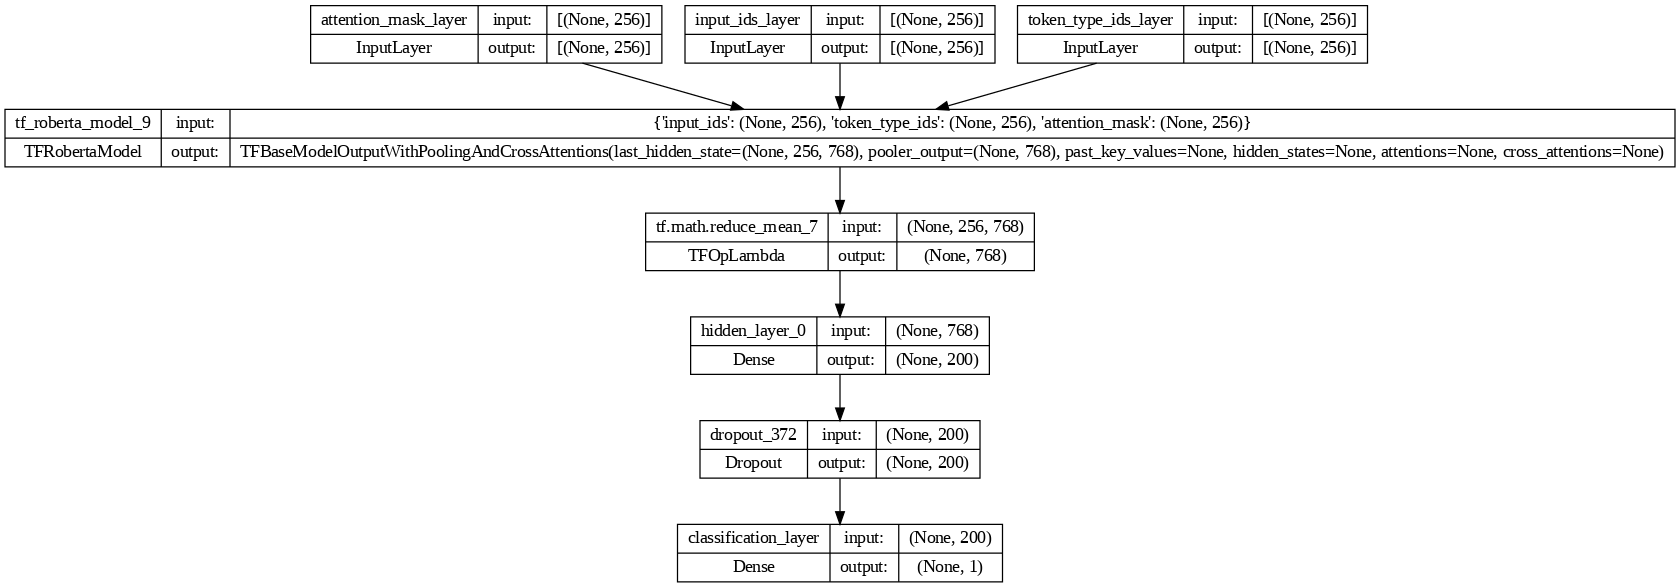

In [ ]:
tf.keras.utils.plot_model(model_1_base, show_shapes=True, dpi=90)

### Fit


In [ ]:
model_base1_history = model_1_base.fit(roberta_train_inputs,
                          y_train,
                          validation_data=(roberta_val_inputs, y_val),
                          batch_size=32,
                          epochs=3
                          )

Epoch 1/3
301/301 [==============================] - 230s 699ms/step - loss: 0.6678 - accuracy: 0.5864 - val_loss: 0.6021 - val_accuracy: 0.7376
Epoch 2/3
301/301 [==============================] - 220s 731ms/step - loss: 0.5810 - accuracy: 0.7176 - val_loss: 0.5634 - val_accuracy: 0.7569
Epoch 3/3
301/301 [==============================] - 220s 732ms/step - loss: 0.5288 - accuracy: 0.7554 - val_loss: 0.5431 - val_accuracy: 0.7575


### Visualize

In [ ]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

  # loss
  axes[0].plot(model_history.history['loss'], color='darkturquoise', label='train_losses')
  axes[0].plot(model_history.history['val_loss'], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss')
  axes[0].legend()

  # accuracy
  axes[1].plot(model_history.history['accuracy'], color='darkturquoise', label='train_accuracy')
  axes[1].plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy')
  axes[1].legend()

  plt.show()

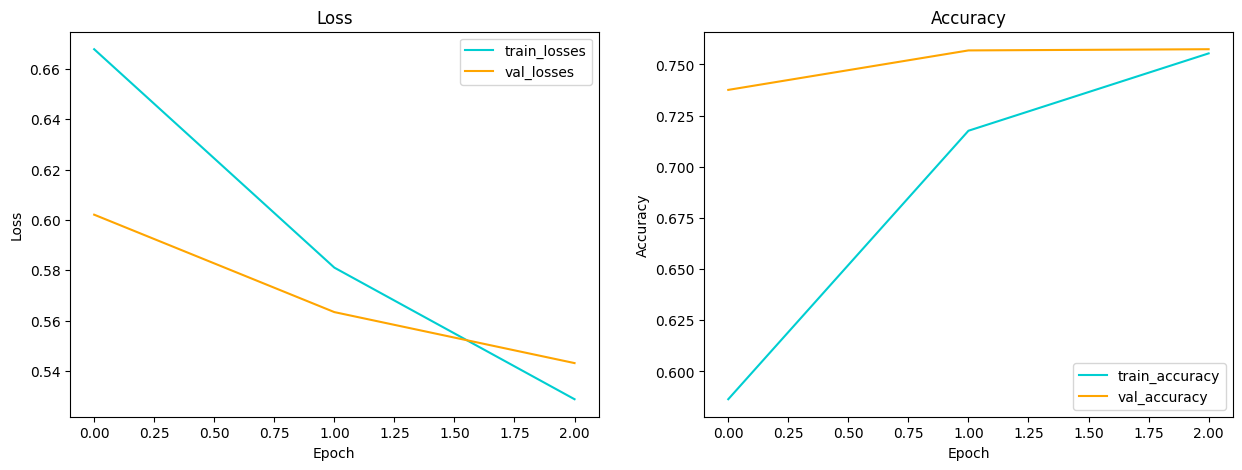

In [ ]:
visualize(model_base1_history)

## roberta_base_2
- roberta-large
- reduce_mean on last_hidden_state
- **num_unfreeze = 4**
- hidden_size=200
- dropout=0.3
- learning_rate=0.0000005
- batch_size=4
- epoches=6

### Build

In [ ]:
roberta_base_model = TFRobertaModel.from_pretrained(checkpoint)
model_2_base = create_roberta_classification_model(roberta_base_model, num_unfreeze=4, learning_rate=0.0000005)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

retrain layers:  ['_23', '_22', '_21', '_20']


In [ ]:
model_2_base.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                    

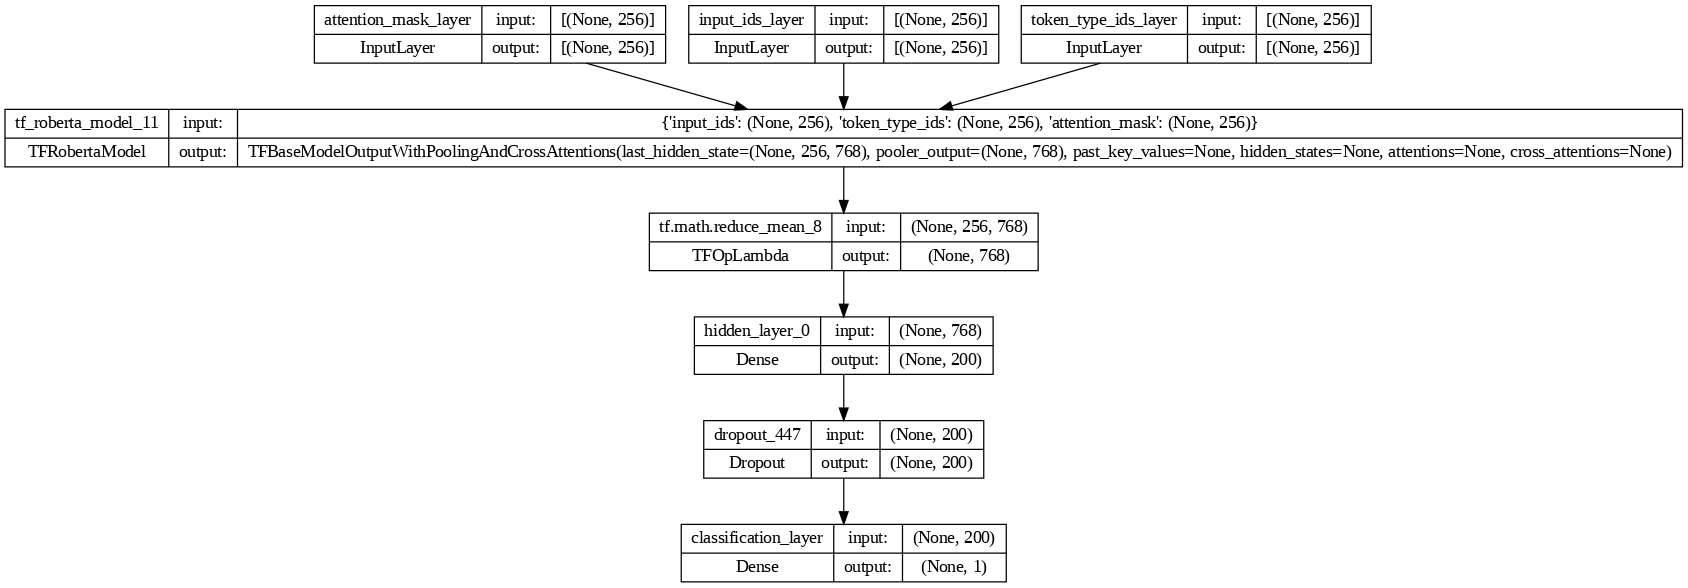

In [ ]:
tf.keras.utils.plot_model(model_2_base, show_shapes=True, dpi=90)

### Fit


In [ ]:
model_base2_history = model_2_base.fit(roberta_train_inputs,
                          y_train,
                          validation_data=(roberta_val_inputs, y_val),
                          batch_size=4,
                          epochs=6
                          )

Epoch 1/6
2401/2401 [==============================] - 282s 117ms/step - loss: 0.7877 - accuracy: 0.4978 - val_loss: 0.8698 - val_accuracy: 0.2864
Epoch 2/6
2401/2401 [==============================] - 294s 122ms/step - loss: 0.7377 - accuracy: 0.5058 - val_loss: 0.7921 - val_accuracy: 0.2899
Epoch 3/6
2401/2401 [==============================] - 285s 119ms/step - loss: 0.7164 - accuracy: 0.5060 - val_loss: 0.7451 - val_accuracy: 0.3431
Epoch 4/6
2401/2401 [==============================] - 279s 116ms/step - loss: 0.7007 - accuracy: 0.5252 - val_loss: 0.7161 - val_accuracy: 0.4056
Epoch 5/6
2401/2401 [==============================] - 269s 112ms/step - loss: 0.6915 - accuracy: 0.5381 - val_loss: 0.6976 - val_accuracy: 0.4804
Epoch 6/6
2401/2401 [==============================] - 267s 111ms/step - loss: 0.6820 - accuracy: 0.5588 - val_loss: 0.6853 - val_accuracy: 0.5786


### Visualize

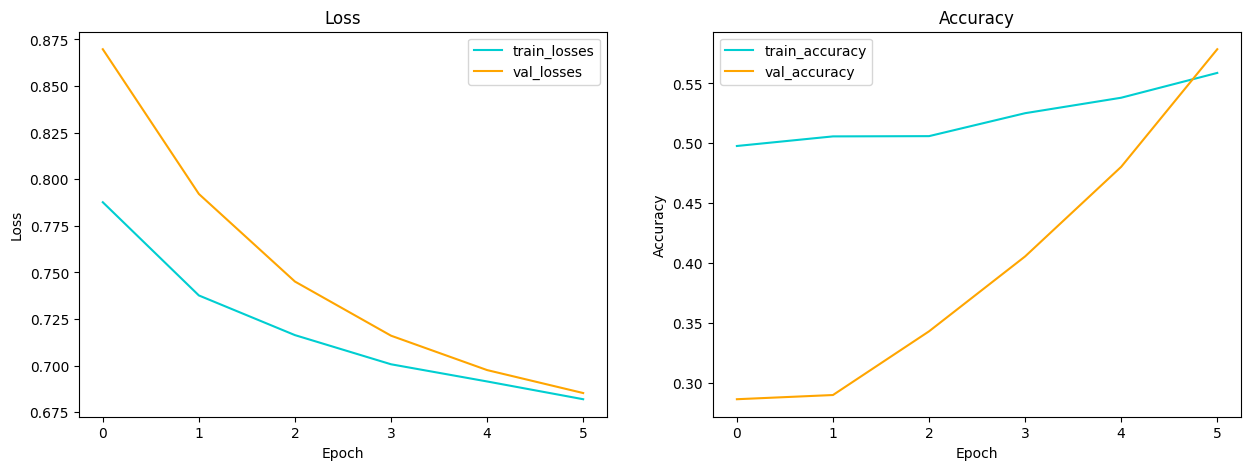

In [ ]:
visualize(model_base2_history)

## roberta_base_3


*   roberta-base
*   reduce_mean on last_hidden_state
*   num_unfreeze = 0
*   hidden_size= [1024,512]
*   dropout=0.1
*   learning_rate=0.00005
*   batch_size=32
*   epochs=3



### Build

In [ ]:
roberta_base_model = TFRobertaModel.from_pretrained(checkpoint)
roberta_base_3 = create_roberta_classification_model(roberta_base_model, num_unfreeze=0, hidden_size= [1024,512],dropout=0.1,learning_rate=0.00005)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
roberta_base_3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 256)]                0         []                            
 tLayer)                                                                                    

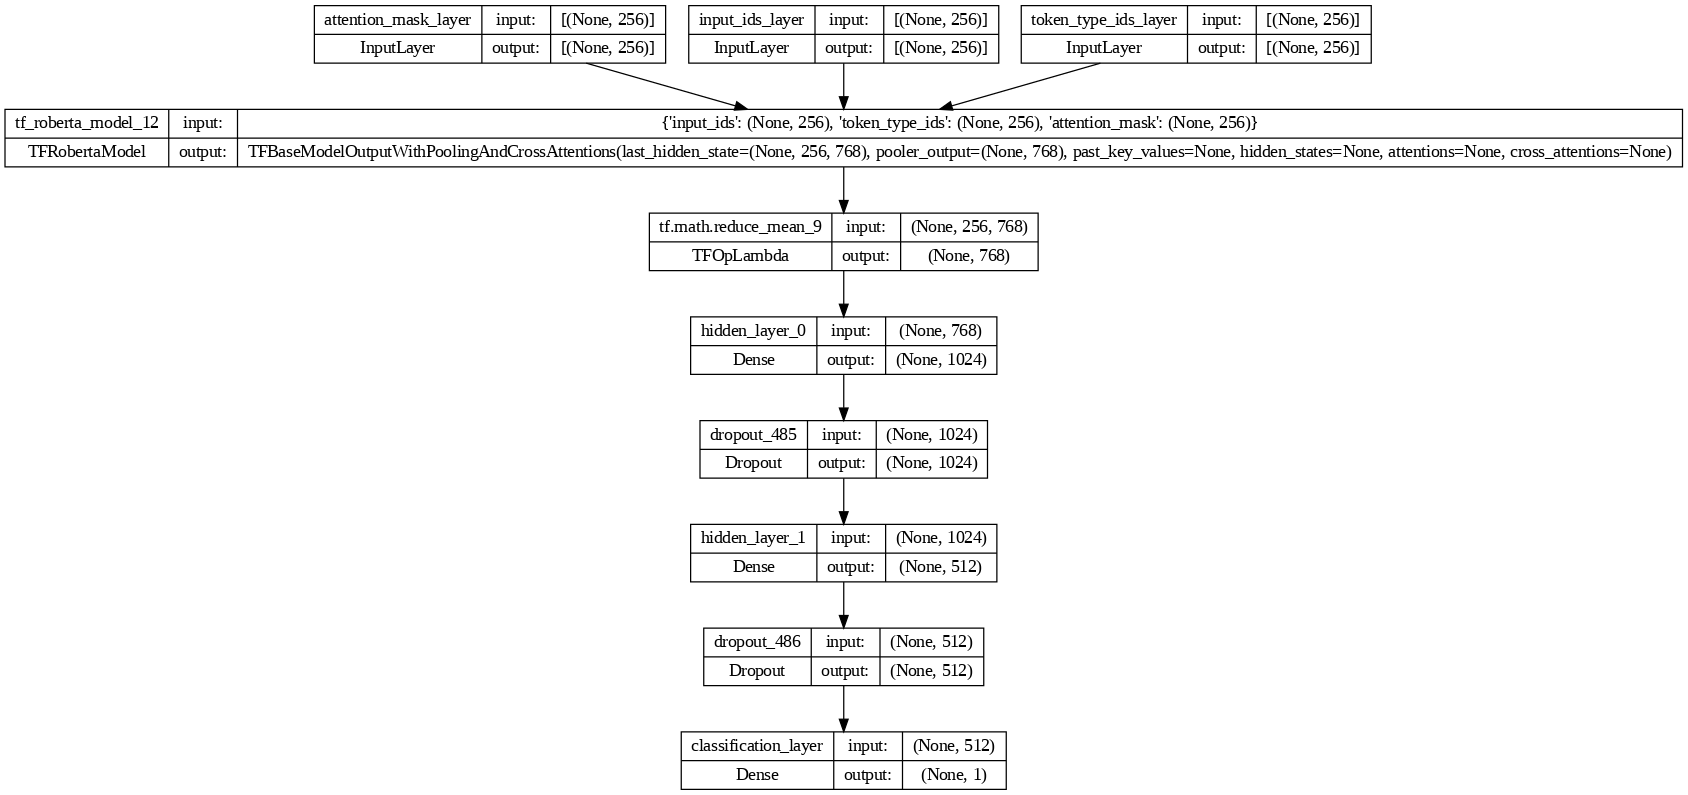

In [ ]:
tf.keras.utils.plot_model(roberta_base_3, show_shapes=True, dpi=90)

### Fit

In [ ]:
roberta_base_3_history = roberta_base_3.fit(roberta_train_inputs,
                          y_train,
                          validation_data=(roberta_val_inputs, y_val),
                          batch_size=32,
                          epochs=3
                          )

Epoch 1/3
301/301 [==============================] - 227s 700ms/step - loss: 0.5705 - accuracy: 0.7112 - val_loss: 0.5359 - val_accuracy: 0.7165
Epoch 2/3
301/301 [==============================] - 220s 732ms/step - loss: 0.4681 - accuracy: 0.7809 - val_loss: 0.5144 - val_accuracy: 0.7621
Epoch 3/3
301/301 [==============================] - 220s 732ms/step - loss: 0.4412 - accuracy: 0.7937 - val_loss: 0.5204 - val_accuracy: 0.7282


### Visualize

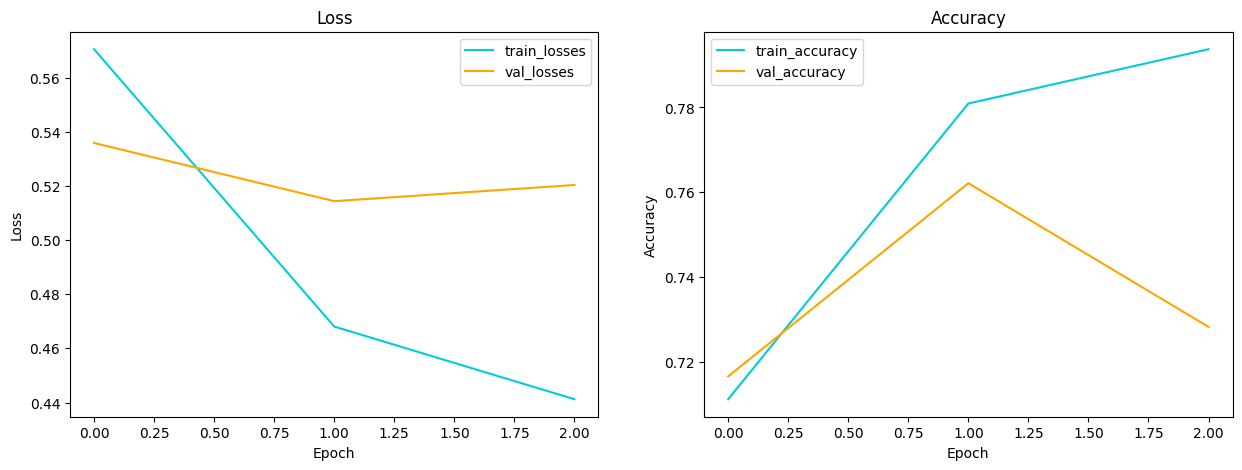

In [ ]:
visualize(roberta_base_3_history)

## roberta_base_4
- roberta-base
- reduce_mean on last_hidden_state
- num_unfreeze = 4
- hidden_size= [1024,512]
- dropout=0.1
- learning_rate=0.0000005
- batch_size=4
- epochs=6

### Build

In [ ]:
roberta_base_model = TFRobertaModel.from_pretrained(checkpoint)
model_4_base = create_roberta_classification_model(roberta_base_model, num_unfreeze=4, hidden_size= [1024,512],dropout=0.1,learning_rate=0.0000005)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

retrain layers:  ['_23', '_22', '_21', '_20']


### Fit

In [ ]:
model_4_base_history = model_4_base.fit(roberta_train_inputs,
                          y_train,
                          validation_data=(roberta_val_inputs, y_val),
                          batch_size=4,
                          epochs=6
                          )

Epoch 1/6


2401/2401 [==============================] - 238s 97ms/step - loss: 0.6994 - accuracy: 0.5217 - val_loss: 0.6889 - val_accuracy: 0.5687
Epoch 2/6
2401/2401 [==============================] - 229s 95ms/step - loss: 0.6805 - accuracy: 0.5759 - val_loss: 0.6622 - val_accuracy: 0.7043
Epoch 3/6
2401/2401 [==============================] - 229s 95ms/step - loss: 0.6715 - accuracy: 0.6157 - val_loss: 0.6597 - val_accuracy: 0.6739
Epoch 4/6
2401/2401 [==============================] - 229s 95ms/step - loss: 0.6628 - accuracy: 0.6429 - val_loss: 0.6519 - val_accuracy: 0.6803
Epoch 5/6
2401/2401 [==============================] - 229s 95ms/step - loss: 0.6521 - accuracy: 0.6721 - val_loss: 0.6486 - val_accuracy: 0.6844
Epoch 6/6
2401/2401 [==============================] - 229s 95ms/step - loss: 0.6436 - accuracy: 0.6850 - val_loss: 0.6396 - val_accuracy: 0.6826


### Visualize

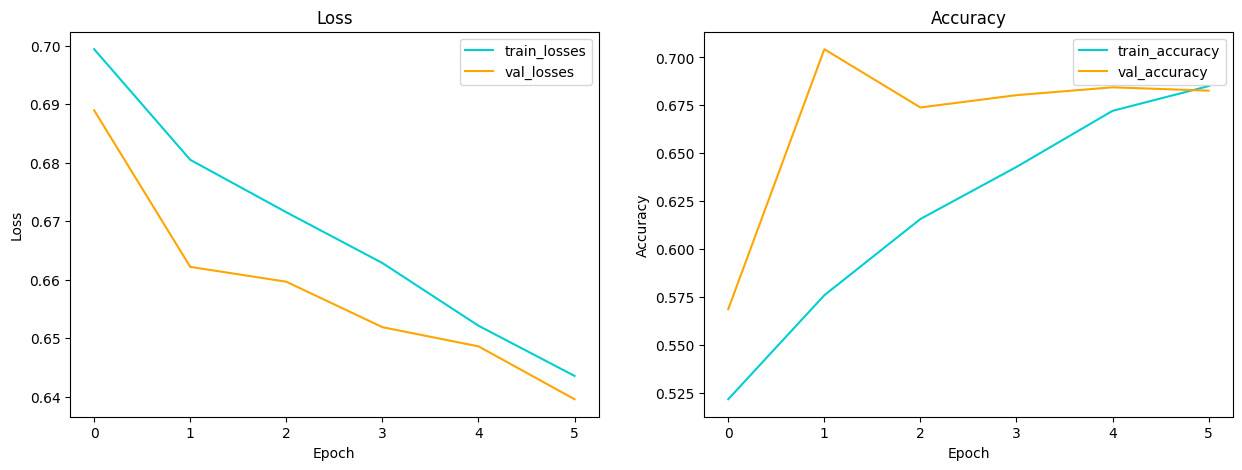

In [ ]:
visualize(model_4_base_history)